----------------------------------------
Number of features: 5
Features: ['value', 'sin52', 'cos52', 'sin12', 'cos12']
----------------------------------------
Epoch 1/200
28/28 - 3s - 99ms/step - loss: 0.4316 - val_loss: 0.4521
Epoch 2/200
28/28 - 1s - 28ms/step - loss: 0.2752 - val_loss: 0.2239
Epoch 3/200
28/28 - 1s - 27ms/step - loss: 0.2324 - val_loss: 0.2483
Epoch 4/200
28/28 - 1s - 27ms/step - loss: 0.2166 - val_loss: 0.2668
Epoch 5/200
28/28 - 1s - 27ms/step - loss: 0.2040 - val_loss: 0.2054
Epoch 6/200
28/28 - 1s - 27ms/step - loss: 0.1985 - val_loss: 0.2236
Epoch 7/200
28/28 - 1s - 28ms/step - loss: 0.1815 - val_loss: 0.1433
Epoch 8/200
28/28 - 1s - 29ms/step - loss: 0.1698 - val_loss: 0.1434
Epoch 9/200
28/28 - 1s - 29ms/step - loss: 0.1772 - val_loss: 0.1234
Epoch 10/200
28/28 - 1s - 28ms/step - loss: 0.1640 - val_loss: 0.1586
Epoch 11/200
28/28 - 1s - 29ms/step - loss: 0.1728 - val_loss: 0.1742
Epoch 12/200
28/28 - 1s - 27ms/step - loss: 0.1658 - val_loss: 0.2414
Epoch 13/

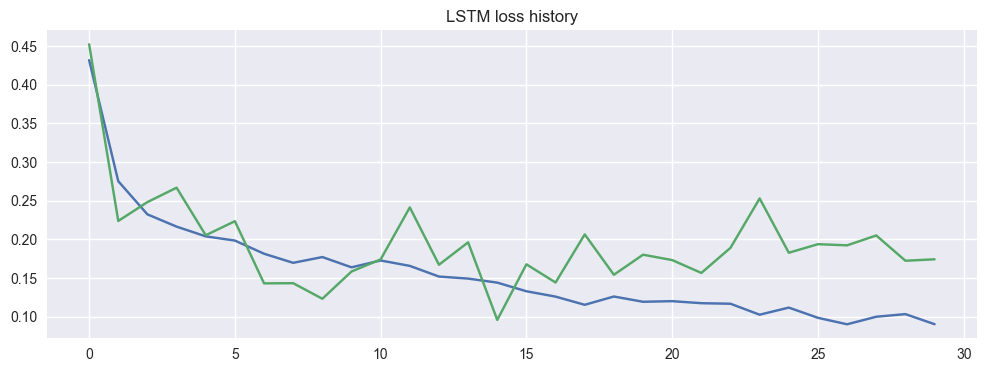

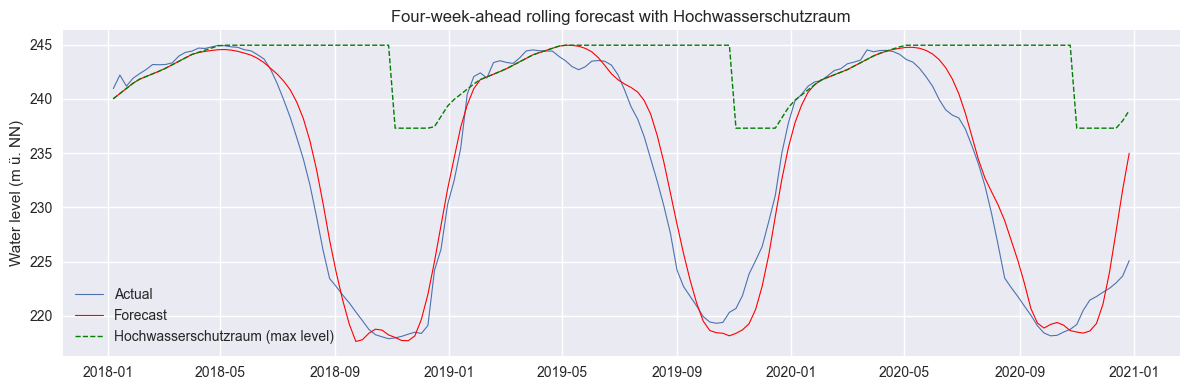

In [ ]:
# ---------------------------------------------------------------
# 0. Imports
# ---------------------------------------------------------------
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, LSTM, Dropout, Dense
from tensorflow.keras.callbacks import EarlyStopping
import joblib
from tqdm.auto import tqdm

# ---------------------------------------------------------------
# 1. Load daily data → weekly means (Sun-anchored)
# ---------------------------------------------------------------
df = pd.read_csv("../data/processed/water_levels_daily.csv",
                 parse_dates=["timestamp"])

weekly = (
    df.set_index("timestamp")["value"]
      .resample("W-SUN").mean()
      .interpolate()
)

# ---------------------------------------------------------------
# 2. Build DataFrame with deterministic seasonality
#    – keep target 'value' in the first column
# ---------------------------------------------------------------
weekly_df = weekly.to_frame(name="value")

# --- Add cyclical week features ---
week_no = weekly_df.index.isocalendar().week.astype(int)    # 1 … 52/53
weekly_df["sin52"] = np.sin(2 * np.pi * week_no / 52)
weekly_df["cos52"] = np.cos(2 * np.pi * week_no / 52)

# --- Add cyclical month features ---
month_no = weekly_df.index.month
weekly_df["sin12"] = np.sin(2 * np.pi * month_no / 12)
weekly_df["cos12"] = np.cos(2 * np.pi * month_no / 12)

# ---------------------------------------------------------------
# 3. Dynamic cap
# ---------------------------------------------------------------
anchor_template = [
    ("11-01", 237.30), ("12-15", 237.30), ("01-01", 239.61),
    ("02-01", 241.71), ("03-01", 242.70), ("04-01", 244.10),
    ("05-01", 244.95),
]

def compute_max_level_series(dates):
    def max_level_on(date):
        y0 = date.year if date.month >= 11 else date.year - 1
        pts = []
        for md, lvl in anchor_template:
            m, d = map(int, md.split("-"))
            yr = y0 if m >= 11 else y0 + 1
            # handle 29 Feb on non-leap yrs
            try:
                pts.append((pd.Timestamp(yr, m, d), lvl))
            except ValueError:
                pts.append((pd.Timestamp(yr, 2, 28), lvl))
        pts.sort(key=lambda x: x[0])
        if date < pts[0][0] or date >= pts[-1][0]:
            return pts[-1][1]
        for (d0, l0), (d1, l1) in zip(pts, pts[1:]):
            if d0 <= date <= d1:
                frac = (date - d0) / (d1 - d0)
                return l0 + frac * (l1 - l0)
        return pts[-1][1]

    return pd.Series([max_level_on(d) for d in dates], index=dates,
                     name="max_level_m")

max_level = compute_max_level_series(weekly_df.index)

# ---------------------------------------------------------------
# 4. Train / validation split
# ---------------------------------------------------------------
train_df      = weekly_df.loc[: "2017-12-31"]
validation_df = weekly_df.loc["2018-01-01" : "2020-12-31"]

# ---------------------------------------------------------------
# 5. Scaling
# ---------------------------------------------------------------
scaler = StandardScaler()
train_scaled      = scaler.fit_transform(train_df)
validation_scaled = scaler.transform(validation_df)

# ---------------------------------------------------------------
# 6. Window generator 
# ---------------------------------------------------------------
LOOKBACK = 52        # weeks
HORIZON  = 4         # predict t + 3 (4-week ahead)

def make_windows(arr, lookback=LOOKBACK, horizon=HORIZON):
    X, y = [], []
    for i in range(lookback, len(arr) - horizon + 1):
        X.append(arr[i - lookback : i, :])     # all features
        y.append(arr[i + horizon - 1, 0])      # only 'value'
    return np.array(X), np.array(y)

# -------- training windows ----------
X_train, y_train = make_windows(train_scaled)

# -------- validation windows --------
PAD_LEN   = LOOKBACK + HORIZON - 1
padding   = train_scaled[-PAD_LEN:]
val_block = np.vstack([padding, validation_scaled])
X_val, y_val = make_windows(val_block)

# to Keras shapes
X_train = X_train.astype("float32")
X_val   = X_val.astype("float32")

# ---------------------------------------------------------------
# 7. LSTM model
# ---------------------------------------------------------------
n_features = X_train.shape[2]
print("-" * 40)
print(f"Number of features: {n_features}")
print(f"Features: {[f for f in weekly_df.columns]}")
print("-" * 40)

model = Sequential([
    Input(shape=(LOOKBACK, n_features)), 
    LSTM(128, return_sequences=True),
    Dropout(0.2),
    LSTM(128),
    Dropout(0.2),
    Dense(1)
])

model.compile(optimizer="adam", loss="mse")

es = EarlyStopping(monitor="val_loss", patience=15,
                   restore_best_weights=True)

history = model.fit(
    X_train, y_train,
    epochs=200,
    batch_size=32,
    validation_data=(X_val, y_val),
    callbacks=[es],
    verbose=2,
)

# Save model
model.save("../models/water_level_lstm.keras")  # lightweight .keras file
joblib.dump(scaler, "../models/LSTM_standard_scaler.joblib")

# ---------------------------------------------------------------
# 8. Forecast on validation set
# ---------------------------------------------------------------
validation_pred_scaled = model.predict(X_val, verbose=0).flatten()
validation_act_scaled  = y_val

# ---------- NEW inverse-scaling logic (only column-0) ----------
target_mean  = scaler.mean_[0]
target_scale = scaler.scale_[0]

validation_pred = validation_pred_scaled * target_scale + target_mean
validation_act  = validation_act_scaled  * target_scale + target_mean

# ---------------------------------------------------------------
# 9. Apply dynamic cap
# ---------------------------------------------------------------
MIN_VAL = 205.0
cap_val = max_level.loc[validation_df.index].values

pred_capped = np.maximum(validation_pred, MIN_VAL)
pred_final  = np.minimum(pred_capped, cap_val)

# ---------------------------------------------------------------
# 10. Metrics
# ---------------------------------------------------------------
validation_results = pd.DataFrame({
    "Actual":    validation_act,
    "Predicted": pred_final,
}, index=validation_df.index)

rmse = np.sqrt(mean_squared_error(validation_results["Actual"],
                                  validation_results["Predicted"]))
mae  = mean_absolute_error(validation_results["Actual"],
                           validation_results["Predicted"])

print("-" * 40)
print(f"Validation MAE  : {mae:5.2f}")
print(f"Validation RMSE : {rmse:5.2f}")
print("-" * 40)


# ---------------------------------------------------------------
# 11. Plot results
# ---------------------------------------------------------------

# Plot loss history
plt.figure(figsize=(12, 4))
plt.plot(history.history["loss"], label="train loss")
plt.plot(history.history["val_loss"], label="validation loss")
plt.title("LSTM loss history")


# Plot actuals & forecasts
fig, ax = plt.subplots(figsize=(12,4))

# 1) plot actuals & forecasts
ax.plot(validation_results.index, validation_results['Actual'], label='Actual', lw=.8)
ax.plot(validation_results.index, validation_results['Predicted'], label='Forecast', color='red', lw=.8)

# 2) plot the buffer‐level (max allowed) as a dashed line
ax.plot(max_level.loc[validation_results.index],
        label='Hochwasserschutzraum (max level)',
        color='green', linestyle='--', lw=1)


ax.set_title("Four-week-ahead rolling forecast with Hochwasserschutzraum")
ax.set_ylabel("Water level (m ü. NN)")
ax.legend(loc='lower left')
plt.tight_layout()
plt.show()